In [1]:
import numpy as np
import pandas as pd
from sklearn import linear_model
import matplotlib.pyplot as plt
import seaborn as sns
from sqlalchemy import create_engine
import statsmodels.api as sm
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_absolute_error
from statsmodels.tools.eval_measures import mse, rmse
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV, ElasticNetCV

import warnings
warnings.filterwarnings('ignore')

In [2]:
#load data
postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'houseprices'

engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))
house_df = pd.read_sql_query('select * from houseprices',con=engine)

# no need for an open connection, as we're only doing a single query
engine.dispose()

In [3]:
#look at first few rows of data
house_df.head()

,id,mssubclass,mszoning,lotfrontage,lotarea,street,alley,lotshape,landcontour,utilities,...,poolarea,poolqc,fence,miscfeature,miscval,mosold,yrsold,saletype,salecondition,saleprice
0,1,60,RL,65.0,8450,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,12,2008,WD,Normal,250000


In [4]:
#get variable types and info
house_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
id               1460 non-null int64
mssubclass       1460 non-null int64
mszoning         1460 non-null object
lotfrontage      1201 non-null float64
lotarea          1460 non-null int64
street           1460 non-null object
alley            91 non-null object
lotshape         1460 non-null object
landcontour      1460 non-null object
utilities        1460 non-null object
lotconfig        1460 non-null object
landslope        1460 non-null object
neighborhood     1460 non-null object
condition1       1460 non-null object
condition2       1460 non-null object
bldgtype         1460 non-null object
housestyle       1460 non-null object
overallqual      1460 non-null int64
overallcond      1460 non-null int64
yearbuilt        1460 non-null int64
yearremodadd     1460 non-null int64
roofstyle        1460 non-null object
roofmatl         1460 non-null object
exterior1st      1460 non-n

This dataset has 81 variables; 43 are string-type objects, 3 are floats, and 35 are integers.

In [5]:
#check for missing data
house_df.isnull().sum()*100/house_df.isnull().count()

id                0.000000
mssubclass        0.000000
mszoning          0.000000
lotfrontage      17.739726
lotarea           0.000000
                   ...    
mosold            0.000000
yrsold            0.000000
saletype          0.000000
salecondition     0.000000
saleprice         0.000000
Length: 81, dtype: float64

Most of the variables do not have any missing values; however, some variables are missing values for more than 90% of the data. Those variables will probably not make sense to use as part of the linear regression. If we use variables that are missing a smaller part of the data for the linear regression, we will replace the missing values.

In [6]:
#get correlation between variables
house_df[['saleprice', 'id', 'mssubclass', 'lotfrontage', 'lotarea', 'overallqual', 'overallcond','yearbuilt', 
          'yearremodadd', 'masvnrarea', 'bsmtfinsf1', 'bsmtfinsf2', 'bsmtunfsf', 'totalbsmtsf', 'firstflrsf',
         'secondflrsf', 'lowqualfinsf', 'grlivarea', 'bsmtfullbath', 'bsmthalfbath', 'fullbath', 'halfbath', 'bedroomabvgr',
         'kitchenabvgr', 'totrmsabvgrd', 'fireplaces', 'garageyrblt', 'garagecars', 'garagearea', 'wooddecksf',
         'openporchsf', 'enclosedporch', 'threessnporch', 'screenporch', 'poolarea', 'miscval', 'mosold', 'yrsold']].corr()

,saleprice,id,mssubclass,lotfrontage,lotarea,overallqual,overallcond,yearbuilt,yearremodadd,masvnrarea,...,garagearea,wooddecksf,openporchsf,enclosedporch,threessnporch,screenporch,poolarea,miscval,mosold,yrsold
saleprice,1.000000,-0.021917,-0.084284,0.351799,0.263843,0.790982,-0.077856,0.522897,0.507101,0.477493,...,0.623431,0.324413,0.315856,-0.128578,0.044584,0.111447,0.092404,-0.021190,0.046432,-0.028923
id,-0.021917,1.000000,0.011156,-0.010601,-0.033226,-0.028365,0.012609,-0.012713,-0.021998,-0.050298,...,0.017634,-0.029643,-0.000477,0.002889,-0.046635,0.001330,0.057044,-0.006242,0.021172,0.000712
mssubclass,-0.084284,0.011156,1.000000,-0.386347,-0.139781,0.032628,-0.059316,0.027850,0.040581,0.022936,...,-0.098672,-0.012579,-0.006100,-0.012037,-0.043825,-0.026030,0.008283,-0.007683,-0.013585,-0.021407
lotfrontage,0.351799,-0.010601,-0.386347,1.000000,0.426095,0.251646,-0.059213,0.123349,0.088866,0.193458,...,0.344997,0.088521,0.151972,0.010700,0.070029,0.041383,0.206167,0.003368,0.011200,0.007450
lotarea,0.263843,-0.033226,-0.139781,0.426095,1.000000,0.105806,-0.005636,0.014228,0.013788,0.104160,...,0.180403,0.171698,0.084774,-0.018340,0.020423,0.043160,0.077672,0.038068,0.001205,-0.014261
overallqual,0.790982,-0.028365,0.032628,0.251646,0.105806,1.000000,-0.091932,0.572323,0.550684,0.411876,...,0.562022,0.238923,0.308819,-0.113937,0.030371,0.064886,0.065166,-0.031406,0.070815,-0.027347
overallcond,-0.077856,0.012609,-0.059316,-0.059213,-0.005636,-0.091932,1.000000,-0.375983,0.073741,-0.128101,...,-0.151521,-0.003334,-0.032589,0.070356,0.025504,0.054811,-0.001985,0.068777,-0.003511,0.043950
yearbuilt,0.522897,-0.012713,0.027850,0.123349,0.014228,0.572323,-0.375983,1.000000,0.592855,0.315707,...,0.478954,0.224880,0.188686,-0.387268,0.031355,-0.050364,0.004950,-0.034383,0.012398,-0.013618
yearremodadd,0.507101,-0.021998,0.040581,0.088866,0.013788,0.550684,0.073741,0.592855,1.000000,0.179618,...,0.371600,0.205726,0.226298,-0.193919,0.045286,-0.038740,0.005829,-0.010286,0.021490,0.035743
masvnrarea,0.477493,-0.050298,0.022936,0.193458,0.104160,0.411876,-0.128101,0.315707,0.179618,1.000000,...,0.373066,0.159718,0.125703,-0.110204,0.018796,0.061466,0.011723,-0.029815,-0.005965,-0.008201


First, I looked at the correlation between sale price and the numeric variables. Next, I narrowed this set of variables down to those that had the highest correlation with sale price.

In [7]:
#sale price correlation with selected variables
house_df[['saleprice', 'overallqual', 'totalbsmtsf', 'firstflrsf','grlivarea', 'garagecars', 'garagearea']].corr()

,saleprice,overallqual,totalbsmtsf,firstflrsf,grlivarea,garagecars,garagearea
saleprice,1.000000,0.790982,0.613581,0.605852,0.708624,0.640409,0.623431
overallqual,0.790982,1.000000,0.537808,0.476224,0.593007,0.600671,0.562022
totalbsmtsf,0.613581,0.537808,1.000000,0.819530,0.454868,0.434585,0.486665
firstflrsf,0.605852,0.476224,0.819530,1.000000,0.566024,0.439317,0.489782
grlivarea,0.708624,0.593007,0.454868,0.566024,1.000000,0.467247,0.468997
garagecars,0.640409,0.600671,0.434585,0.439317,0.467247,1.000000,0.882475
garagearea,0.623431,0.562022,0.486665,0.489782,0.468997,0.882475,1.000000


The variables that had the highest correlation with sale price were overall quality, total square feet of basement area, first floor square feet, above ground living area square feet, size of garage in car capacity, and size of garage in square feet. These are the numeric variables that will be used for the linear regression. Next, I will confirm that there are no missing values for these variables.

In [8]:
#confirm there are no missing values for selected variables
house_df[['saleprice', 'overallqual', 'totalbsmtsf', 'firstflrsf','grlivarea', 'garagecars', 
          'garagearea']].isnull().sum()*100/house_df[['saleprice', 'overallqual', 'totalbsmtsf', 'firstflrsf',
         'grlivarea', 'garagecars', 'garagearea']].isnull().count()

saleprice      0.0
overallqual    0.0
totalbsmtsf    0.0
firstflrsf     0.0
grlivarea      0.0
garagecars     0.0
garagearea     0.0
dtype: float64

There are no missing values for these variables that need to be replaced, so we can move on to looking at the non-numerical variables. 

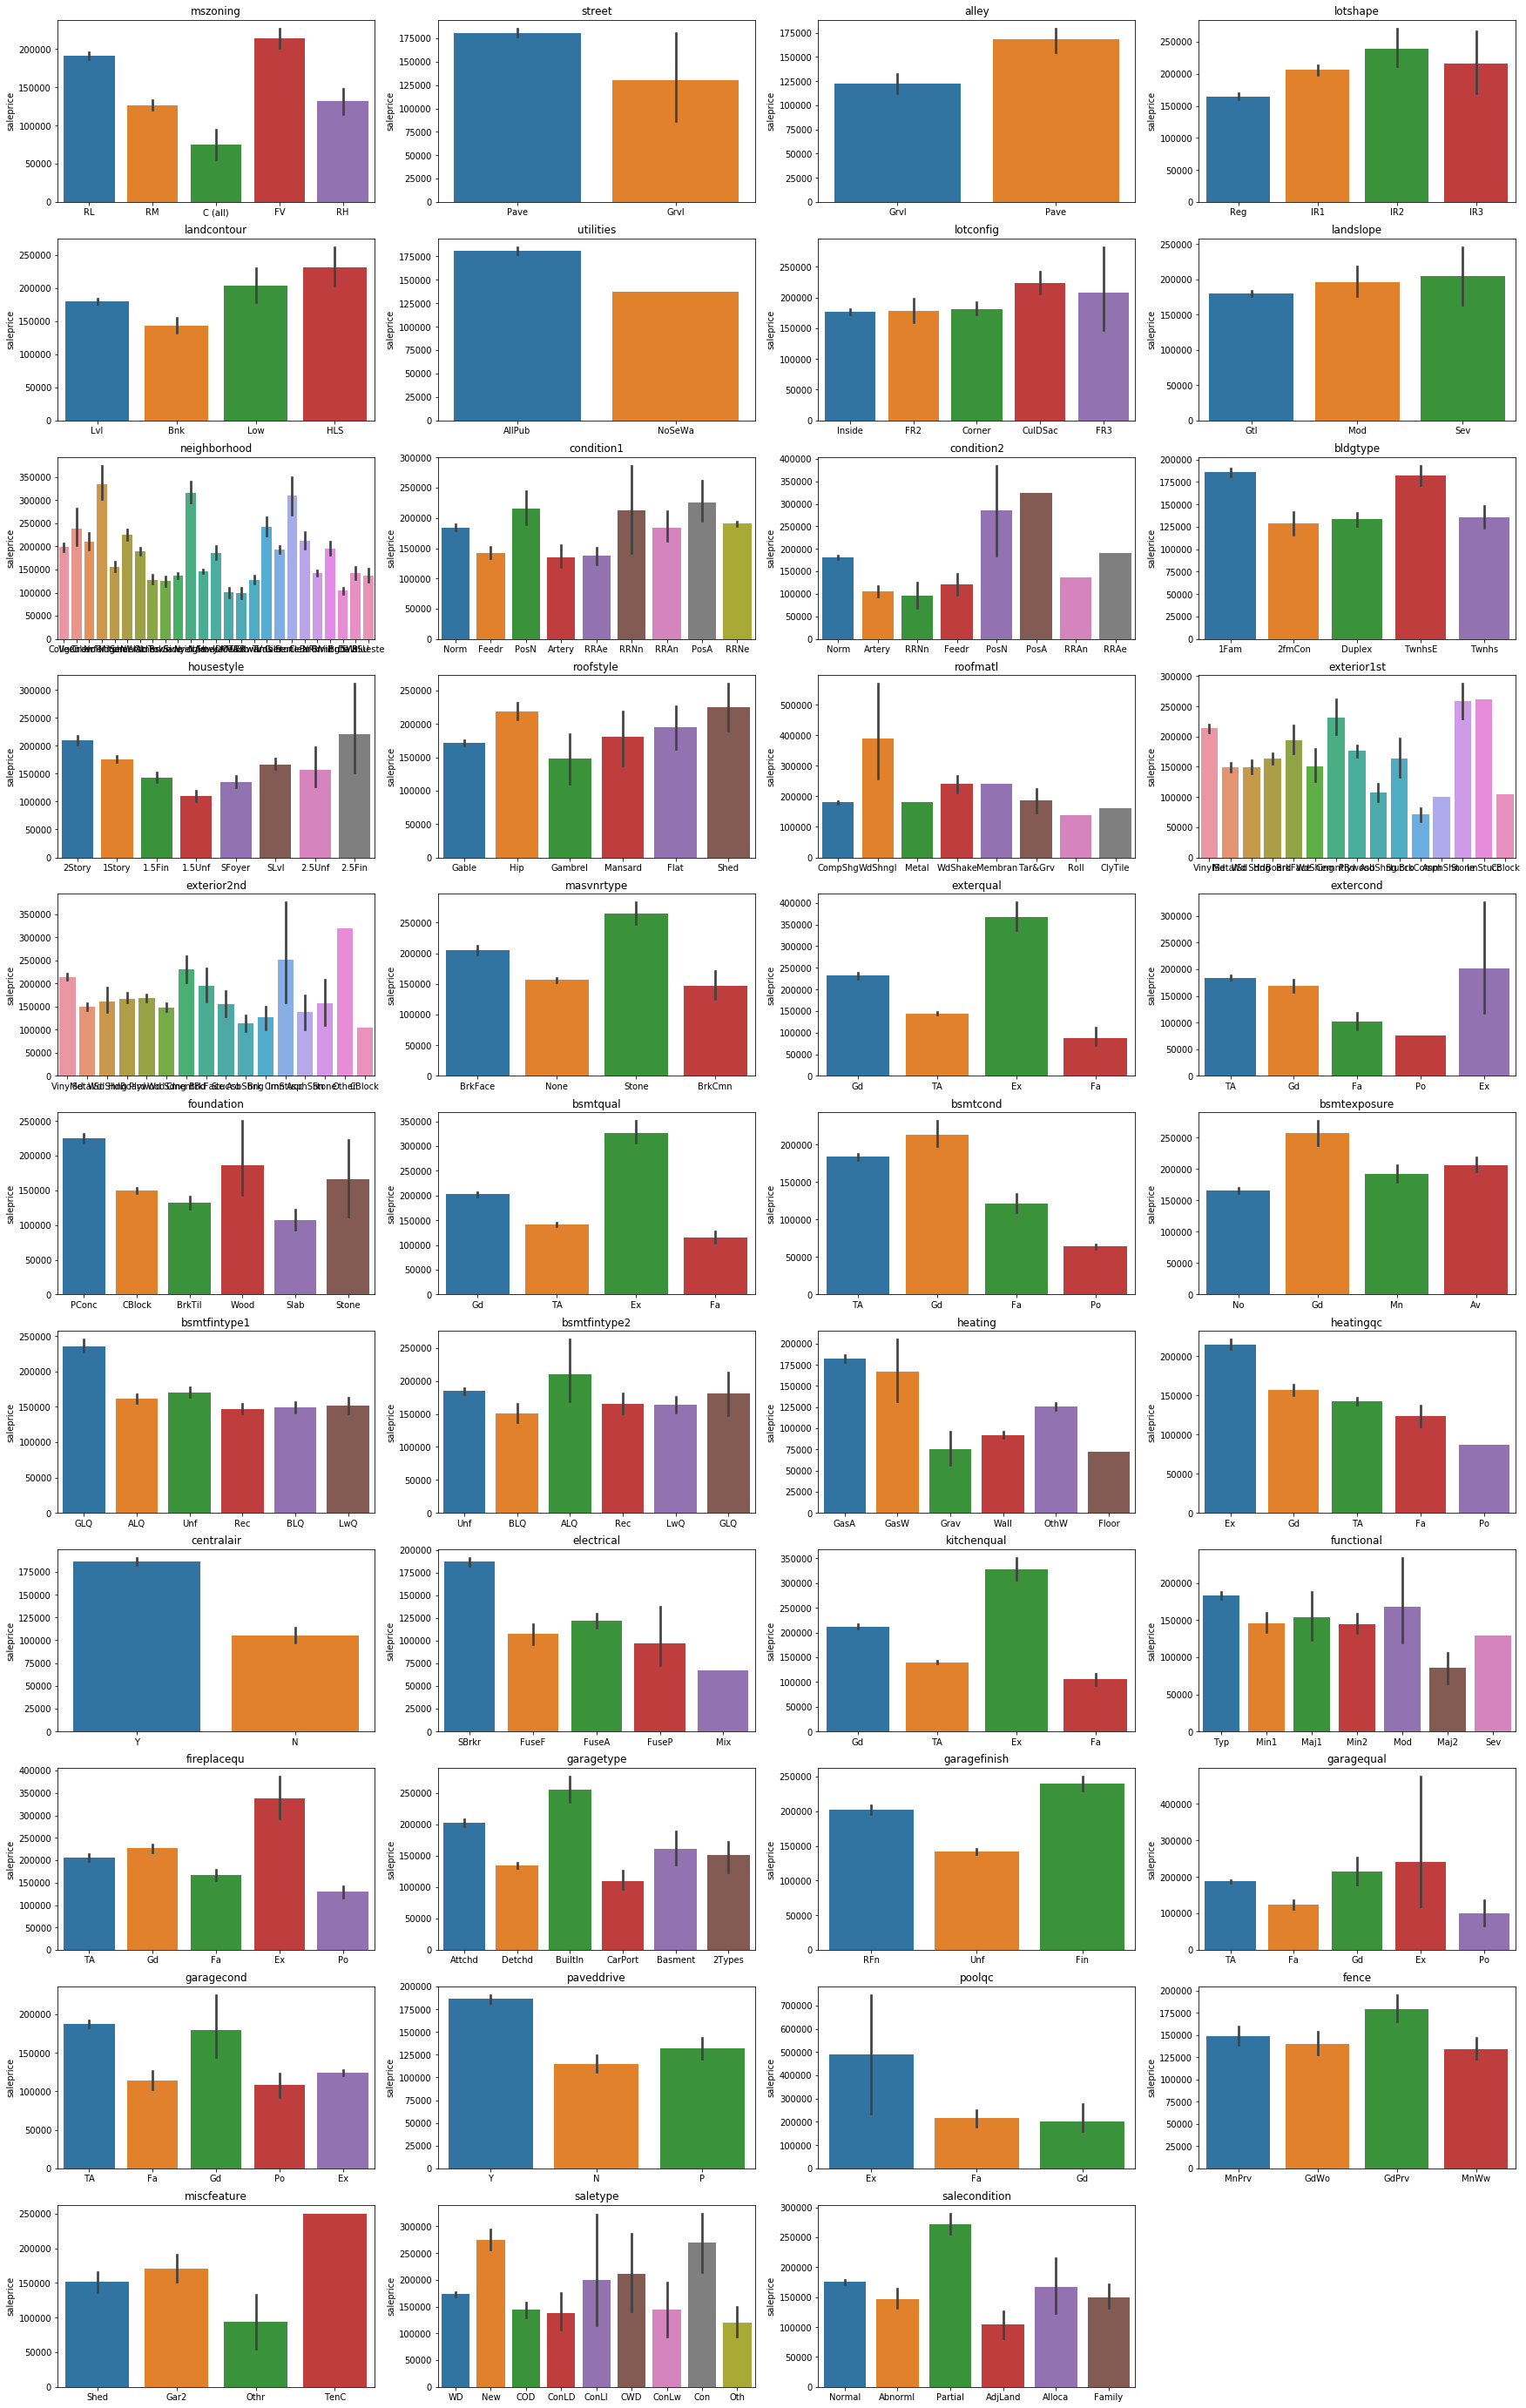

In [9]:
#plot of non-numerical variables
categories = ['mszoning', 'street', 'alley', 'lotshape', 'landcontour', 'utilities', 'lotconfig', 'landslope', 'neighborhood',
             'condition1', 'condition2', 'bldgtype', 'housestyle', 'roofstyle', 'roofmatl', 'exterior1st', 'exterior2nd',
             'masvnrtype', 'exterqual', 'extercond', 'foundation', 'bsmtqual', 'bsmtcond', 'bsmtexposure', 'bsmtfintype1',
             'bsmtfintype2', 'heating', 'heatingqc', 'centralair', 'electrical', 'kitchenqual', 'functional', 'fireplacequ',
             'garagetype', 'garagefinish', 'garagequal', 'garagecond', 'paveddrive', 'poolqc', 'fence', 'miscfeature',
             'saletype', 'salecondition']
plt.figure(figsize=(30,50))
for index, var in enumerate(categories):
    plt.subplot(11, 4, index+1)
    sns.barplot(house_df[var], house_df['saleprice'])
    plt.title(var)
    plt.xlabel('')

plt.show()

Based on the charts above, I will select variables that show differences between categories to include in the linear regression model.

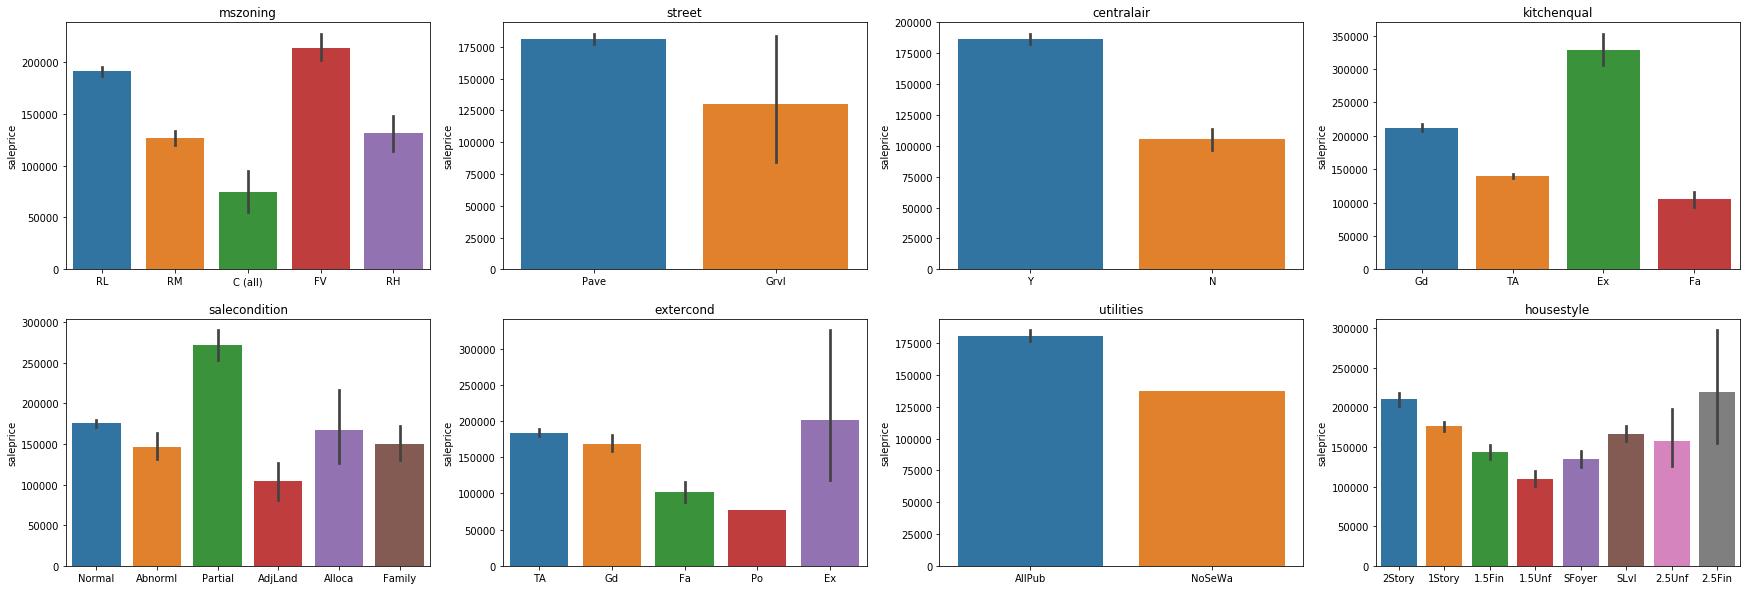

In [10]:
#plot selected variables
categories2 = ['mszoning', 'street','centralair', 'kitchenqual', 'salecondition', 'extercond', 'utilities', 'housestyle']
plt.figure(figsize=(30,10))
for index, var in enumerate(categories2):
    plt.subplot(2, 4, index+1)
    sns.barplot(house_df[var], house_df['saleprice'])
    plt.title(var)
    plt.xlabel('')

plt.show()

In [11]:
#confirm selected variables are not missing data
house_df[categories2].isnull().sum()*100/house_df[categories2].isnull().count()

mszoning         0.0
street           0.0
centralair       0.0
kitchenqual      0.0
salecondition    0.0
extercond        0.0
utilities        0.0
housestyle       0.0
dtype: float64

There are no missing values for the selected variables, so there is nothing that needs to be replaced. Next, I will create the necessary dummy variables to use in the linear regression and define the dependent and independent variables for our regressions.

In [12]:
#create dummy variables
house_df = pd.concat([house_df,pd.get_dummies(house_df.mszoning, prefix='mszoning', drop_first=True)], axis=1)
zoning_column_names = list(pd.get_dummies(house_df.mszoning, prefix='mszoning', drop_first=True).columns)
house_df['street_access'] = pd.get_dummies(house_df.street, drop_first=True)
house_df['has_AC'] = pd.get_dummies(house_df.centralair, drop_first=True)
house_df = pd.concat([house_df,pd.get_dummies(house_df.kitchenqual, prefix='kitchenqual', drop_first=True)], axis=1)
kitchen_column_names = list(pd.get_dummies(house_df.kitchenqual, prefix='kitchenqual', drop_first=True).columns)
house_df = pd.concat([house_df,pd.get_dummies(house_df.salecondition, prefix='salecondition', drop_first=True)], axis=1)
condition_column_names = list(pd.get_dummies(house_df.salecondition, prefix='salecondition', drop_first=True).columns)
house_df = pd.concat([house_df,pd.get_dummies(house_df.extercond, prefix='extercond', drop_first=True)], axis=1)
exterior_column_names = list(pd.get_dummies(house_df.extercond, prefix='extercond', drop_first=True).columns)
house_df['util_type'] = pd.get_dummies(house_df.utilities, drop_first=True)
house_df = pd.concat([house_df,pd.get_dummies(house_df.housestyle, prefix='housestyle', drop_first=True)], axis=1)
style_column_names = list(pd.get_dummies(house_df.housestyle, prefix='housestyle', drop_first=True).columns)

In [13]:
#target variable
Y = house_df['saleprice']
#feature set
X = house_df[['overallqual', 'totalbsmtsf', 'firstflrsf','grlivarea', 'garagecars', 'garagearea', 
             'street_access', 'has_AC', 'util_type'] + zoning_column_names + kitchen_column_names + condition_column_names + 
             exterior_column_names + style_column_names]
#split data
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 465)

Next, we will run a series of regressions: Linear, Lasso, Ridge, and ElasticNet to see which one performs best.

In [14]:
#define linear model
linear_model = LinearRegression()
linear_model.fit(X_train, Y_train)

Y_preds_train = linear_model.predict(X_train)
Y_preds_test = linear_model.predict(X_test)

print('R-squared of the model on the training set is: {}'.format(linear_model.score(X_train, Y_train)))

R-squared of the model on the training set is: 0.8017922563000102


In [15]:
#set range of values for alpha
alphas = [np.power(10.0,p) for p in np.arange(-10,40,1)]

#define Lasso regression
lasso_cv = LassoCV(alphas=alphas, cv=10)

lasso_cv.fit(X_train, Y_train)

Y_preds_train = lasso_cv.predict(X_train)
Y_preds_test = lasso_cv.predict(X_test)

print('Best alpha value is: {}'.format(lasso_cv.alpha_))
print('R-squared of the model on the training set is: {}'.format(lasso_cv.score(X_train, Y_train)))

Best alpha value is: 10.0
R-squared of the model on the training set is: 0.8017217757791846


In [16]:
#define Ridge Regression
ridge_cv = RidgeCV(alphas=alphas, cv=10)

ridge_cv.fit(X_train, Y_train)

Y_preds_train = ridge_cv.predict(X_train)
Y_preds_test = ridge_cv.predict(X_test)

print('Best alpha value is: {}'.format(ridge_cv.alpha_))
print('R-squared of the model on the training set is: {}'.format(ridge_cv.score(X_train, Y_train)))

Best alpha value is: 1.0
R-squared of the model on the training set is: 0.8015861184023373


In [17]:
#define ElasticNet regression
elastic_net_cv = ElasticNetCV(alphas=alphas, cv=10)

elastic_net_cv.fit(X_train, Y_train)

Y_preds_train = elastic_net_cv.predict(X_train)
Y_preds_test = elastic_net_cv.predict(X_test)

print('Best alpha value is: {}'.format(elastic_net_cv.alpha_))
print('R-squared of the model on the training set is: {}'.format(elastic_net_cv.score(X_train, Y_train)))

Best alpha value is: 0.001
R-squared of the model on the training set is: 0.8017079277673959


Although all of the regressions performed similarly based on their R-squared values, the linear model performed slightly better than the rest on the training set, so that is the model that we will use here on the test set.

In [18]:
print('-----Test set statistics-----')
print('R-squared of the model on the test set is: {}'.format(linear_model.score(X_test, Y_test)))
print('Mean absolute error of the prediction is: {}'.format(mean_absolute_error(Y_test, Y_preds_test)))
print('Mean squared error of the prediction is: {}'.format(mse(Y_test, Y_preds_test)))
print('Root mean squared error of the prediction is: {}'.format(rmse(Y_test, Y_preds_test)))
print('Mean absolute percentage error of the prediction is: {}'.format(np.mean(np.abs((Y_test - Y_preds_test) / Y_test)) * 100))


-----Test set statistics-----
R-squared of the model on the test set is: 0.8063007208950401
Mean absolute error of the prediction is: 23811.562124587374
Mean squared error of the prediction is: 1294073313.3180897
Root mean squared error of the prediction is: 35973.230509895686
Mean absolute percentage error of the prediction is: 14.18019737135065


The model performs similarly on the test set and the training set.

Next, I will incorporate data about interest rates into the model. This data is available on Kaggle here : https://www.kaggle.com/federalreserve/interest-rates/download.

In [19]:
#get interest rate data
interest_rates = pd.read_csv('index.csv')
interest_rates.head()

,Year,Month,Day,Federal Funds Target Rate,Federal Funds Upper Target,Federal Funds Lower Target,Effective Federal Funds Rate,Real GDP (Percent Change),Unemployment Rate,Inflation Rate
0,1954,7,1,NaN,NaN,NaN,0.80,4.6,5.8,NaN
1,1954,8,1,NaN,NaN,NaN,1.22,NaN,6.0,NaN
2,1954,9,1,NaN,NaN,NaN,1.06,NaN,6.1,NaN
3,1954,10,1,NaN,NaN,NaN,0.85,8.0,5.7,NaN
4,1954,11,1,NaN,NaN,NaN,0.83,NaN,5.3,NaN


In order to a single row per sale when we merge our data, we want to select the interest rates from the first of the month to represent the month. Then we will merge the interest rates data with the house prices data.

In [20]:
#select data from the first of the month
interest_rates = interest_rates[interest_rates['Day'] == 1]

In [21]:
#merge house prices data and interest rates data
merged_house_df = pd.merge(house_df, interest_rates, left_on=['yrsold','mosold'], right_on =['Year', 'Month'])
merged_house_df.head()

,id,mssubclass,mszoning,lotfrontage,lotarea,street,alley,lotshape,landcontour,utilities,...,Year,Month,Day,Federal Funds Target Rate,Federal Funds Upper Target,Federal Funds Lower Target,Effective Federal Funds Rate,Real GDP (Percent Change),Unemployment Rate,Inflation Rate
0,1,60,RL,65.0,8450,Pave,None,Reg,Lvl,AllPub,...,2008,2,1,3.0,NaN,NaN,2.98,NaN,4.9,2.3
1,11,20,RL,70.0,11200,Pave,None,Reg,Lvl,AllPub,...,2008,2,1,3.0,NaN,NaN,2.98,NaN,4.9,2.3
2,202,20,RL,75.0,10125,Pave,None,Reg,Lvl,AllPub,...,2008,2,1,3.0,NaN,NaN,2.98,NaN,4.9,2.3
3,269,30,RM,71.0,6900,Pave,None,Reg,Lvl,AllPub,...,2008,2,1,3.0,NaN,NaN,2.98,NaN,4.9,2.3
4,423,20,RL,100.0,21750,Pave,None,Reg,HLS,AllPub,...,2008,2,1,3.0,NaN,NaN,2.98,NaN,4.9,2.3


In [22]:
#check for missing data
merged_house_df.isnull().sum()*100/merged_house_df.isnull().count()

id                               0.000000
mssubclass                       0.000000
mszoning                         0.000000
lotfrontage                     17.739726
lotarea                          0.000000
                                  ...    
Federal Funds Lower Target      64.863014
Effective Federal Funds Rate     0.000000
Real GDP (Percent Change)       64.246575
Unemployment Rate                0.000000
Inflation Rate                   0.000000
Length: 117, dtype: float64

After merging the data, there are no missing values for Effective Federal Funds Rate, Unemployment Rate, or Inflation Rate, so I will add those variables to the model and see what happens.

In [23]:
#target variable
Y = merged_house_df['saleprice']
#feature set
X = merged_house_df[['overallqual', 'totalbsmtsf', 'firstflrsf','grlivarea', 'garagecars', 'garagearea', 
             'street_access', 'has_AC', 'util_type', 'Effective Federal Funds Rate', 'Unemployment Rate', 'Inflation Rate']
             + zoning_column_names + kitchen_column_names + condition_column_names + exterior_column_names + 
             style_column_names]
#split data
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 465)

In [24]:
#define linear model
linear_model = LinearRegression()
linear_model.fit(X_train, Y_train)

Y_preds_train = linear_model.predict(X_train)
Y_preds_test = linear_model.predict(X_test)

print('R-squared of the model on the training set is: {}'.format(linear_model.score(X_train, Y_train)))
print('-----Test set statistics-----')
print('R-squared of the model on the test set is: {}'.format(linear_model.score(X_test, Y_test)))
print('Mean absolute error of the prediction is: {}'.format(mean_absolute_error(Y_test, Y_preds_test)))
print('Mean squared error of the prediction is: {}'.format(mse(Y_test, Y_preds_test)))
print('Root mean squared error of the prediction is: {}'.format(rmse(Y_test, Y_preds_test)))
print('Mean absolute percentage error of the prediction is: {}'.format(np.mean(np.abs((Y_test - Y_preds_test) / Y_test)) * 100))

R-squared of the model on the training set is: 0.8006179778503432
-----Test set statistics-----
R-squared of the model on the test set is: 0.8147119555205837
Mean absolute error of the prediction is: 23062.437694948076
Mean squared error of the prediction is: 1053476982.4315867
Root mean squared error of the prediction is: 32457.310153978975
Mean absolute percentage error of the prediction is: 14.165841967171833


This model performs very similarly to the original model, although the revised model performs slightly better on the test set. One thing to note about our addition of these variables is that the value is the same for all houses sold in a particular month. This means that months in which more houses were sold will be factored in more heavily.